# Winning Jeopardy

Jeopardy is a popular TV show in the US where participants answer questions to win money. It's been running for a few decades, and is a major force in popular culture. 

Let's say we want to compete on Jeopardy, and we're looking for any edge we can get to win. In this project, we'll work with a dataset of Jeopardy questions to figure out some patterns in the questions that could help us win.

**Project Goal**
In this project, we'll work with a dataset of Jeopardy questions to figure out some patterns in the questions that could help us win.

This project was motivated as part of the guided project series on [dataquest](http://dataquest.io/). The analysis is an extended version of the guided project.

## Jeopardy Questions

Let's explore the jeopardy questions. We will see that the dataset contains the following columns:

* `Show Number` -- the Jeopardy episode number of the show this question was in.
* `Air Date` -- the date the episode aired.
* `Round` -- the round of Jeopardy that the question was asked in. Jeopardy has several rounds as each episode progresses.
* `Category` -- the category of the question.
* `Value` -- the number of dollars answering the question correctly is worth.
* `Question` -- the text of the question.
* `Answer` -- the text of the answer.

Let's start our exploration with first of all loading the complete Jeopardy Question csv file from this [reddit post](https://www.reddit.com/r/datasets/comments/1uyd0t/200000_jeopardy_questions_in_a_json_file/). The csv file was downloaded and added to the folder location.

In [1]:
import pandas as pd
from string import punctuation
import re
import matplotlib.pyplot as plt
from scipy.stats import chisquare

# read in the dataset
jeopardy = pd.read_csv('jeopardy.csv')
jeopardy.columns

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')

We can see that the names of each column contain an additional space. Let's remove those and keep the name only.

In [2]:
# clean column names from additional spaces
jeopardy.columns = jeopardy.columns.str.replace(' ', '')
jeopardy.columns

Index(['ShowNumber', 'AirDate', 'Round', 'Category', 'Value', 'Question',
       'Answer'],
      dtype='object')

In [3]:
jeopardy.shape

(216930, 7)

In [4]:
jeopardy.head()

,ShowNumber,AirDate,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


Our dataset contains 216930 questions.

## Normalizing Text

Before we start with our analysis, we need to normalize the text, that is ensure lowercase words and remove punctuation. There are two ways we can go about this. Let's see which one is more efficient.

In [5]:
# function to normalize the text using python string library
def normalize_text(s):
    s = str(s).lower()
    s = s.translate(str.maketrans('', '', punctuation))
    return s

# function to normalize the text using regex
def normalize_text_reg(s):
    s = str(s).lower()
    s = re.sub("[^A-Za-z0-9\s]", "", s)
    return s

s = 'Hello.?! World.*'
%timeit normalize_text(s)
%timeit normalize_text_reg(s)

3.26 µs ± 38.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
3.26 µs ± 194 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


We can observe that using the function with regular expression seems to be much faster. We will use it to treat and normalize our `Question` and `Answer` columns.

In [6]:
# normalize our columns
jeopardy['clean_question'] = jeopardy['Question'].apply(normalize_text_reg)
jeopardy['clean_answer'] = jeopardy['Answer'].apply(normalize_text_reg)

In [7]:
jeopardy.head()

,ShowNumber,AirDate,Round,Category,Value,Question,Answer,clean_question,clean_answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus,for the last 8 years of his life galileo was u...,copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,no 2 1912 olympian football star at carlisle i...,jim thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona,the city of yuma in this state has a record av...,arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,in 1963 live on the art linkletter show this c...,mcdonalds
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,signer of the dec of indep framer of the const...,john adams


## Normalizing Columns

Now that we have normalized the string columns, let's also normalize `Value` and `Air Date` columns. We will remove the $ sign from the `Value` column and convert the column to numeric; we will also convert `Air Date` to datetime.

In [8]:
# function to normalize value column 
def normalize_value(s):
    s = re.sub("[^A-Za-z0-9\s]", "", s)
    try:
        s = int(s)
    except:
        s = 0
    return s

# clean value column
jeopardy['clean_value'] = jeopardy['Value'].apply(normalize_value)
jeopardy['AirDate'] = pd.to_datetime(jeopardy['AirDate'])

## Answers in Questions

In order to figure out whether to study past questions, study general knowledge, or not study it all, it would be helpful to figure out two things:

* How often the answer is deducible from the question.
* How often new questions are repeats of older questions.

We can answer the first question by seeing how many times words in the answer also occur in the question. We can answer the 2nd question by seeing how often meaningful words occur. Meaningful in this context means words that are not stopwords or words that make sense. Let's tackle the first question first.

In [9]:
# function to count words from answer in the question
def count_terms(row):
    # split the column values by space
    split_answer = row['clean_answer'].split()
    split_question = row['clean_question'].split()    
    
    # initialize count of words
    match_count = 0
    
    # remove 'the' from answers
    if 'the' in split_answer:
        split_answer.remove('the')
    
    # check if answer is 0
    if len(split_answer) == 0:
        return 0
    
    # count ocurrences of answer values in question
    for i in split_answer:
        if i in split_question:
            match_count += 1
    
    # return the calculated count
    return match_count / len(split_answer)
    
# count the words
jeopardy['answer_in_question'] = jeopardy.apply(count_terms, axis=1)

# calculate the mean
jeopardy['answer_in_question'].mean()

0.05792070323661065

In [10]:
jeopardy.head()

,ShowNumber,AirDate,Round,Category,Value,Question,Answer,clean_question,clean_answer,clean_value,answer_in_question
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus,for the last 8 years of his life galileo was u...,copernicus,200,0.0
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,no 2 1912 olympian football star at carlisle i...,jim thorpe,200,0.0
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona,the city of yuma in this state has a record av...,arizona,200,0.0
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,in 1963 live on the art linkletter show this c...,mcdonalds,200,0.0
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,signer of the dec of indep framer of the const...,john adams,200,0.0


We can see that on average the answer shows up in the question around 6% of the time. This tells us that its quite difficult to deduce the answer from the question.

## Recycled Questions

Let's move to tackling our second question, where we need to find out how often new questions are repeats of older ones.

We also should remove uninformative words (e.g stopwords) in order to better understand the question overlap. For this we will use `nltk` package to remove stopwords in the english language.

In [11]:
from nltk.corpus import stopwords

# sorty jeopary values in ascending order
jeopardy.sort_values('AirDate', inplace=True)

# stopwords and used terms
terms_used = set()
stop_words = set(stopwords.words('english'))

# function to calculate the number of times 
# a term from previous questions has been used in new ones
def calculate_overlap(row):
    """
    Returns a word match count (proportion) for each row containing 
    a question back to the 'question_overlap' columns. 
    The count is calculated used a set of words used in previous questions
    
    Parameters:
        row (pandas.Series): row from pandas dataframe       
    
    Returns:
        match_count (float): match count proportion
    
    """
    
    # split the question by space
    split_question = row.split()
    
    # keep only non-stop words
    split_question = [word for word in split_question if word not in stop_words]

    # initialize count
    match_count = 0
    
    # loop through words in split_question: count matches
    for w in split_question:
        if w in terms_used:
            match_count += 1

        # add words to terms used set
        terms_used.add(w)
            
    if len(split_question) > 0:
        match_count /= len(split_question)

    return match_count
        
# run the function on the clean_question column
jeopardy['question_overlap'] = jeopardy['clean_question'].apply(calculate_overlap)

# print the mean overlap
print("Average overlap of questions based on individual words is {}".format(jeopardy['question_overlap'].mean()))

Average overlap of questions based on individual words is 0.9285999315781669


Our results show that there is an 92% overlap between terms in new questions vs terms in old questions. This is quite a strong indicator that new questions tend to include terms from old questions. Nevertheless, this doesn't help us as much since we are only looking at individual terms. 

We could possibly investigate further and look at either phrases or find out how similar questions to each other. To keep this analysis brief, we will not cover it today.

## Low value vs high value questions

Nevertheless, we can also look at questions that pertain high value in terms of money. This strategy can help us earn more money when on Jeopardy.
We can actually figure out which terms correspond to high-value questions using a chi-squared test. We'll first need to narrow down the questions into two categories:

* Low value -- Any row where Value is less than 800.
* High value -- Any row where Value is greater than 800.

Let's write the code which will help us identify value pairs for terms.

In [12]:
# function to find value 
def calculate_value(row):
    value = 1 if row['clean_value'] > 800 else 0
    return value

# determine questions with high value
jeopardy['high_value'] = jeopardy.apply(calculate_value, axis=1)

# function to calculate value pairs (high, low count) for any word
def calc_word(word):
    high_count = 0
    low_count = 0
    
    for index, row in jeopardy.iterrows():
        q = row['clean_question'].split()
        if word in q:
            if row['high_value'] == 1:
                high_count += 1
            else:
                low_count += 1
    
    return high_count, low_count

In [13]:
# empty dictionary to hold the word and 
# counts of high and low value questions the term appears in
observed_expected = {}

# sample terms to run the value function on
comparison_terms = list(terms_used)[:10]

# calculate value pairs (high and low count) for each word in the sample
for word in comparison_terms:
    observed_expected[word] = calc_word(word)

In [14]:
observed_expected

{'flighty': (2, 6),
 'pennants': (0, 2),
 'miltons': (2, 3),
 'hrefhttpwwwjarchivecommedia20110602j12jpg': (0, 1),
 'civilizations': (4, 19),
 'gethsemane': (1, 6),
 'theatera': (1, 1),
 'hotheaded': (1, 1),
 'hrefhttpwwwjarchivecommedia20080403dj30jpg': (1, 0),
 'targetblankolivia': (0, 1)}

## Applying chi-squared test

Now that we've found the observed counts for a few terms, we can compute the expected counts and the chi-squared value.

In [15]:
# find total sum of high and low value questions
high_value_count = jeopardy["high_value"].sum()
low_value_count = jeopardy.shape[0] - high_value_count

# dictionary to hold chisquare and p-value for each term
chi_squared = {}

# loop through the dictionary 
for key, value in observed_expected.items():
    
    # calculate total value of high and low
    total = value[0] + value[1]
    
    # calculate word occurence proportion across the dataset
    total_prop = total / jeopardy.shape[0]
    
    # find expected term for high and low value rows
    high_exp, low_exp = total_prop * high_value_count, total_prop * low_value_count
    
    # calculate chi-squared statistic value and associated p-value
    chi_squared[key] = chisquare(value, (high_exp, low_exp))

In [16]:
chi_squared

{'flighty': Power_divergenceResult(statistic=0.043292301416985354, pvalue=0.8351758561462266),
 'pennants': Power_divergenceResult(statistic=0.7899529284667026, pvalue=0.3741143592744989),
 'miltons': Power_divergenceResult(statistic=0.3363947754070794, pvalue=0.5619176551024535),
 'hrefhttpwwwjarchivecommedia20110602j12jpg': Power_divergenceResult(statistic=0.3949764642333513, pvalue=0.5296950912486695),
 'civilizations': Power_divergenceResult(statistic=1.3519672340861204, pvalue=0.24493449653850868),
 'gethsemane': Power_divergenceResult(statistic=0.6787070195906365, pvalue=0.4100323130964867),
 'theatera': Power_divergenceResult(statistic=0.46338644448358013, pvalue=0.49604555208958945),
 'hotheaded': Power_divergenceResult(statistic=0.46338644448358013, pvalue=0.49604555208958945),
 'hrefhttpwwwjarchivecommedia20080403dj30jpg': Power_divergenceResult(statistic=2.5317964247338085, pvalue=0.11157312838169751),
 'targetblankolivia': Power_divergenceResult(statistic=0.3949764642333513

The results of the chi-squared test show that all of the sample terms we chose are not statistical significant. So far this shows that none of the terms above correspond to high value questions if we defined test significance acceptance level of $p=0.05$

## Exploring Categories

Apart from investigating the values of questions, we can also prepare for jeopardy by knowing the likelihood of certain categories appearning in each round. In our dataset we have a column `Category` which we will use to answer the following questions:

* Which categories appear most often
* What is the probability of each category appearing in each round.

Now, the first question is pretty straight forward. We simply need to count occurences of each category. There are many unique categories, thus we will only look at top 10.

In [17]:
# count number of categories
unique_cats = len(jeopardy["Category"].unique())

print("Number of unique categories {}".format(unique_cats))

Number of unique categories 27995


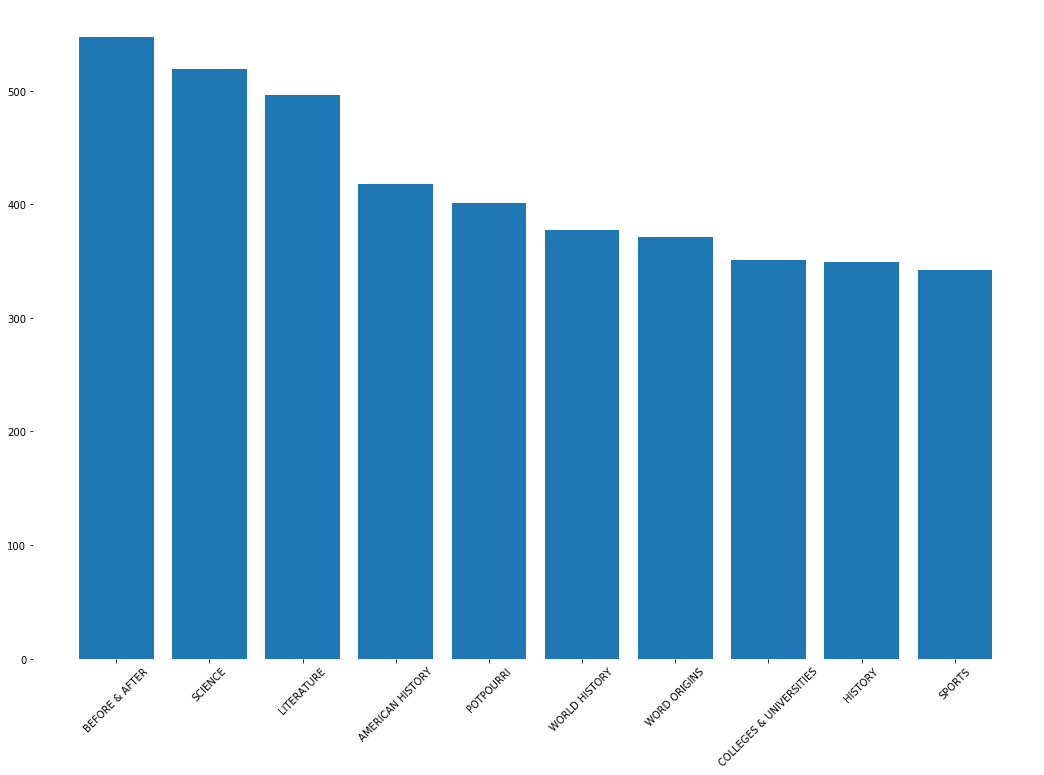

In [18]:
# count category ocurrences
cat_occurs = jeopardy["Category"].value_counts().sort_values(ascending=False).head(10)
fig, ax = plt.subplots(figsize=(18, 12))
ax.bar(cat_occurs.index, cat_occurs)
[ax.spines[a].set_visible(False) for a in ax.spines]
plt.xticks(rotation=45)
plt.show()

The above top 10 categories have more questions than the rest of categories. The category 'Before & After' seems to be the most popular one. For more information on what this category means, you can read [here](https://www.reddit.com/r/serialpodcast/comments/2p2usk/jeopardy_category_serial_before_and_after/).

Now, to find the probability of each category appearing in each round, we need to first group the questions by round and then look at the categories and basically calculate the proportion of questions for a specific category in that round. Let's get to it.

In [19]:
# list of possible rounds
jeopardy["Round"].value_counts()

Jeopardy!           107384
Double Jeopardy!    105912
Final Jeopardy!       3631
Tiebreaker               3
Name: Round, dtype: int64

Jeopardy has only three main rounds with a potential tiebreaker in case of a tie. Let's calculate the occurence of each category by round. 

In [55]:
jeopardy["Round"].value_counts()

Jeopardy!           107384
Double Jeopardy!    105912
Final Jeopardy!       3631
Tiebreaker               3
Name: Round, dtype: int64

In [53]:
# get number of categories by round
catbyround = jeopardy[["Round", "Category", "Question"]].groupby(["Round", "Category"]).agg({'Question': 'count'})

# calculate the proportion of questions for each category in that round
catbyround["Percentage"] = catbyround.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

# check results
catbyround

Since we have lots of categories in each round, we need to think of a way to condense it into a more readable format. For that we can only look at the top 10 categories in each round in terms of probability of occurence.

In [76]:
# groupby Round then take the top 10 largest
catbyround['Percentage'].groupby(level=0, group_keys=False).nlargest(10)

Round             Category               
Double Jeopardy!  BEFORE & AFTER              0.424881
                  LITERATURE                  0.359733
                  SCIENCE                     0.279477
                  WORLD GEOGRAPHY             0.239822
                  OPERA                       0.236045
                  WORLD HISTORY               0.223771
                  BALLET                      0.217161
                  COLLEGES & UNIVERSITIES     0.207720
                  ART                         0.202999
                  ISLANDS                     0.202999
Final Jeopardy!   U.S. PRESIDENTS             1.377031
                  WORD ORIGINS                0.936381
                  STATE CAPITALS              0.853759
                  AUTHORS                     0.743597
                  WORLD LEADERS               0.716056
                  FAMOUS AMERICANS            0.660975
                  FAMOUS NAMES                0.660975
                  HISTO

The above table is a very nice summary of the probability of each category ocurring within each round. Some notable observations are:
* It seems tiebreakers only have three category which equal probability of ocurrence
* US Presidents is a very popular topic in Final Jeopardy! Round with 1.37% chance of ocurrence, which relative to other categories is high
* Literature, science ans sports seem to be quite popular topics touched in every round

## Summary

Here, we have explored the wonderful world of jeopardy and tried to find interesting information that could give us an edge in better preparing for the game and ultimately win in it.